<a href="https://colab.research.google.com/github/Kaushik896/Project_Logistic_Regression_Ranom_Forest/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction:

In this project we are dealing with a data set where we have a classification problem.

This dataset contains about 10 years of daily weather observations from many locations across Australia.

RainTomorrow is the target variable to predict. It means -- did it rain the next day, Yes or No? This column is Yes if the rain for that day was 1mm or more.

### Techniques employed:


1.   `Logistic Regression` : Logistic regression is a commonly used technique for solving binary classification problems. 
2.   `Random Forest and Regularization` : A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The process of reducing overfitting is known as regularlization. 

### Target:
Task is to create a fully automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow. This is a binary classification problem.

In [1]:
# Downloading the dataset

!pip install opendatasets --upgrade --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kaushikthakkar610
Your Kaggle Key: ··········


100%|██████████| 3.83M/3.83M [00:00<00:00, 70.8MB/s]

In [2]:
import os
data_dir = './weather-dataset-rattle-package'
train_csv = data_dir + '/weatherAUS.csv'
import pandas as pd
raw_df = pd.read_csv(train_csv) # 'raw_df' contains the complete data set

"RainToday" seems to be an important column in predicting whether it will rain tommorw or not. So we remove the rows from the dataset which contains NA values in the "RainToday" column.

In [3]:
raw_df.dropna(subset = ['RainToday','RainTomorrow'], inplace = True)

# Exploratory Data analysis and Visualizations:

Here we try to analyse the data set using some statistical graphics. This would tell us about the characteristics and features of the data set and the relationship between different columns in the data.

In [4]:
# installing required libraries
!pip install plotly --quiet
import plotly.express as px
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

In [5]:
# some specifications about the plots
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10,6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [6]:
px.histogram(raw_df, x = 'Location',
             title = 'Location vs. Rainy days',
            color = 'RainToday')

So in our dataset we have approximately 20% of the times it's raining today for almost all locations.
It follows more or less a uniform distribution.

In [39]:
px.histogram(raw_df,
            x = 'Temp3pm',
            title = 'Temperature at 3pm vs. Rain tomorrow',
            color = 'RainTomorrow')

If low temperature at 3pm, it seems more likely to rain tomorrow. But there are cases when the temperature is high but it still rains the next day.

In [40]:
px.histogram(raw_df,
            x = 'RainTomorrow',
            color = "RainToday",
            title = 'Rain tomorrow vs. Rain Today')


If it did not rain today then there is a pretty good chance that it won't rain tomorrow. Predicting rain tomorrow 'yes' is difficult than predicting rain tomorrow 'no'.

In [41]:
px.scatter(raw_df.sample(4000),
          title = 'Min Temp vs. Max Temp',
          x = 'MinTemp',
          y = 'MaxTemp',
           opacity = 0.7,
          color = 'RainToday')

It seems that it rains today if the variation in temperture is small.

In [42]:
px.scatter(raw_df.sample(2000),
        title = 'Temp (3pm) vs. Humidity (3pm)',
        x = 'Temp3pm',
        y = 'Humidity3pm',
        color = 'RainTomorrow')

We can see that if the temperature today is low and humidity is high then there is a fairly good chance of raining tomorrow.

# Training, Validation and Test Sets

We will split our data into three parts namely:

1. **Training set** - We will use this to train the model, i.e., compute the loss and adjust the model's weights using an optimization technique. 


2. **Validation set** - We will use this to evaluate the model during training, tune model hyperparameters (optimization technique, regularization etc.), and pick the best version of the model.


3. **Test set** - We will use this to compare different models or approaches and report the model's final accuracy. The test set should reflect the kind of data the model will encounter in the real-world, as closely as feasible.

In [7]:
!pip install scikit-learn --upgrade --quiet
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 55.5 MB/s eta 0:00:00


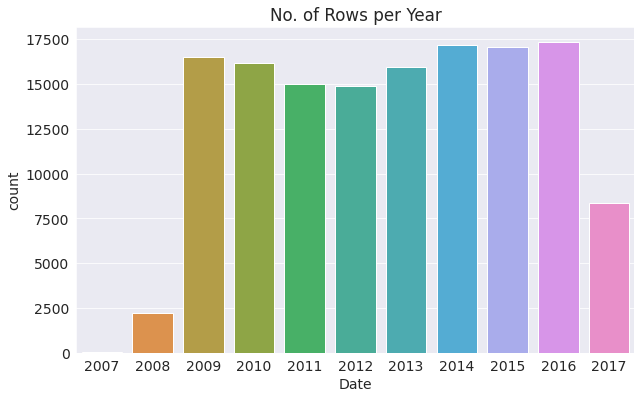

In [8]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year);

While working with dates, it's often a better idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.

For the current dataset, we can use the Date column in the dataset to create another column for year. We'll pick the last two years for the test set, and one year before it for the validation set.

In [9]:
year = pd.to_datetime(raw_df.Date).dt.year
train_df = raw_df[year < 2015] # we will train the model on the data before 2015
val_df = raw_df[year == 2015]  # validation set would consist of data of 2015
test_df = raw_df[year > 2015]  # test set would consist of data after 2015
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (97988, 23)
val_df.shape : (17089, 23)
test_df.shape : (25710, 23)


# Identifying Input and Output columns:
Often, not all the columns in a dataset are useful for training a model. In the current dataset, we can ignore the Date column, since we only want the weather conditions to make a prediction about whether it will rain the next day or not.


In [10]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [11]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [12]:
train_inputs.Location.nunique() # Here the location is surely a categorical values having 49 distict values.


49

In [14]:
!pip install numpy --quiet
import numpy as np
numeric_cols = train_inputs.select_dtypes(include = np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()


In [15]:
train_inputs[numeric_cols].describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,97674.000000,97801.000000,97988.000000,61657.000000,57942.000000,91160.000000,97114.000000,96919.000000,96936.000000,96872.000000,88876.000000,88857.000000,63000.000000,61966.000000,97414.000000,97392.000000
mean,12.007831,23.022202,2.372935,5.289991,7.609004,40.215873,14.092263,18.764608,68.628745,51.469547,1017.513734,1015.132352,4.302952,4.410677,16.835126,21.540138
std,6.347175,6.984397,8.518819,3.952010,3.788813,13.697967,8.984203,8.872398,19.003097,20.756113,7.072510,6.997072,2.866634,2.693370,6.404586,6.831612
min,-8.500000,-4.100000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,979.000000,0.000000,0.000000,-5.900000,-5.100000
25%,7.500000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.800000,1010.400000,1.000000,2.000000,12.200000,16.600000
50%,11.800000,22.400000,0.000000,4.600000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.500000,1015.100000,5.000000,5.000000,16.600000,20.900000
75%,16.600000,27.900000,0.800000,7.200000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.300000,1019.900000,7.000000,7.000000,21.400000,26.200000
max,33.900000,48.100000,371.000000,82.400000,14.300000,135.000000,87.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.100000


In [16]:
train_inputs[categorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

## Imputing Missing Numeric Data

The process of filling missing values in the dataset is called imputing.
The technique used here is: replacing missing values with the average value in the column using the `SimpleImputer` class from `sklearn.impute`



In [17]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'mean')
imputer.fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])
# The missing values are now filled with the column mean


## Scaling Numeric Features

We will scale down the values in the numeric columns to the range of (0,1).
Scaling numeric features ensures that no particular feature has a disproportionate impact on the models loss. Optimization algorithms also work better with smaller numbers.
The numeric columns in out dataset have varying ranges.

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])


## Encoding Categorical Columns

#### One-hot encoding :
It involves adding a new binary(0/1) column for each unique category of a categorical column.

This can be done by using the `OneHotEncoder` class from sklearn.preprocessing 

In [19]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
raw_df[categorical_cols].fillna('unknown')
encoder.fit(raw_df[categorical_cols])

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_encoders.py:828: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



OneHotEncoder(handle_unknown='ignore', sparse=False, sparse_output=False)

The encoder has created a list of categories for each of the categorical columns in the dataset.

We can generate column names for each individual category using `get_feature_names_out`

In [20]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru', 'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia', 'Location_Williamtown', 'Loca

In [21]:
# to perform the encoding, we use the `transform` method of encoder.

train_inputs[encoded_cols] =  encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] =  encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] =  encoder.transform(test_inputs[categorical_cols])



/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented 

In [22]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)
print('test_inputs:', test_inputs.shape)
print('test_targets:', test_targets.shape)

train_inputs: (97988, 123)
train_targets: (97988,)
val_inputs: (17089, 123)
val_targets: (17089,)
test_inputs: (25710, 123)
test_targets: (25710,)


In [23]:
train_targets = pd.DataFrame(train_targets)
val_targets = pd.DataFrame(val_targets)
test_targets = pd.DataFrame(test_targets)

# Training a Logistic Regression Model

Logistic regression is a commonly used technique for solving binary classification problems. In a logistic regression model: 

- we take linear combination (or weighted sum of the input features) 
- we apply the sigmoid function to the result to obtain a number between 0 and 1
- this number represents the probability of the input being classified as "Yes"
- instead of RMSE, the cross entropy loss function is used to evaluate the results.


The sigmoid function applied to the linear combination of inputs has the following formula:

<img src="https://i.imgur.com/sAVwvZP.png" width="400">

To train a logistic regression model, we can use the `LogisticRegression` class from Scikit-learn.

In [24]:
 from sklearn.linear_model import LogisticRegression

In [25]:
model = LogisticRegression(solver = 'liblinear')
model.fit(train_inputs[numeric_cols + encoded_cols], train_targets)
# The targets can be categorical but the inputs cannot be categorical

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LogisticRegression(solver='liblinear')

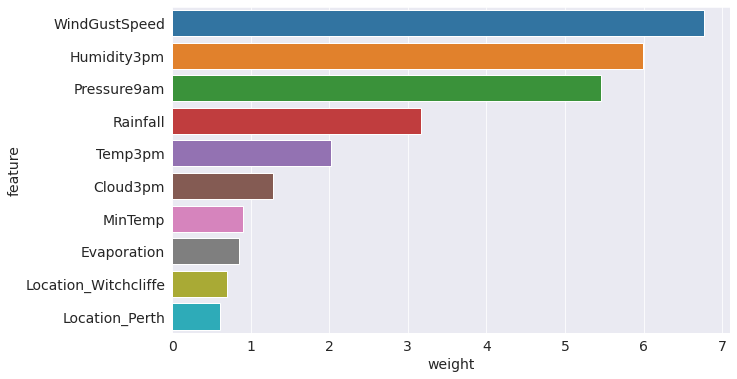

In [26]:
weight_df = pd.DataFrame({
    'feature': numeric_cols + encoded_cols,
    'weight' : model.coef_.tolist()[0]
})
import seaborn as sns
import matplotlib.pyplot as plt

#plt.figure(figsize = (10,50))
sns.barplot(data = weight_df.sort_values('weight', ascending = False).head(10), x = 'weight', y = 'feature')

Each weight is applied to the value in a specific column of the input. Higher the weight, greater the impact of the column on the prediction.

# Making Prediction and Evaluating the model

Here we would evaluate the model on the given data.

In [27]:
x_train = train_inputs[numeric_cols + encoded_cols]
x_val = val_inputs[numeric_cols + encoded_cols]
x_test = test_inputs[numeric_cols + encoded_cols]

In [28]:
train_preds = model.predict(x_train)

In [29]:
from sklearn.metrics import accuracy_score
accuracy_score(train_targets, train_preds)

0.8519206433440829

The model achieves an accuracy of 85.1% on the training set. We can visualize the breakdown of correctly and incorrectly classified inputs using a confusion matrix.

In [30]:
from sklearn.metrics import confusion_matrix
confusion_matrix(train_targets, train_preds, normalize = 'true')

array([[0.94621341, 0.05378659],
       [0.4776585 , 0.5223415 ]])

Let's define a helper function to generate predictions, compute the accuracy score and plot a confusion matrix for a given st of inputs.

In [31]:
def predict_plot(inputs, targets, name = ''):
   preds = model.predict(inputs)

   accuracy = accuracy_score(targets, preds)
   print('Accuracy: {:.2f}%'.format(accuracy*100))

   cf = confusion_matrix(targets, preds, normalize = 'true')
   plt.figure()
   sns.heatmap(cf, annot = True)
   plt.xlabel('Prediction')
   plt.ylabel('targets')
   plt.title('{} Confusion Matrix'.format(name));

   return preds

Accuracy: 85.19%


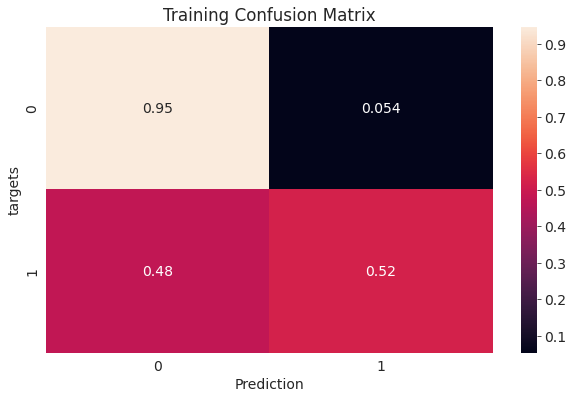

In [32]:
trian_preds = predict_plot(x_train, train_targets, 'Training')

Accuracy: 85.40%


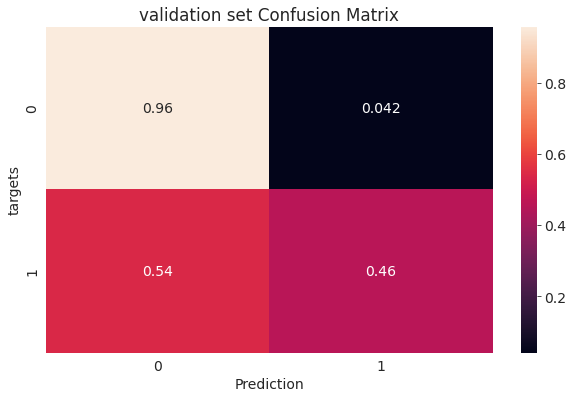

In [33]:
val_preds = predict_plot(x_val, val_targets, 'validation set')


Accuracy: 84.20%


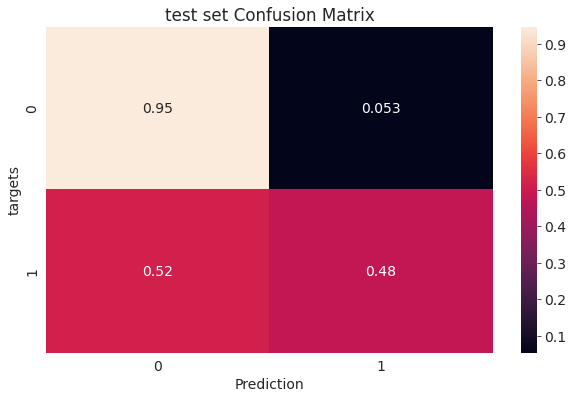

In [34]:
test_preds = predict_plot(x_test, test_targets, 'test set')

The accuracy of the model on the test and validation set are above 84%, which suggests that our model generalizes well to data it hasn't seen before. 

But how good is 84% accuracy? While this depends on the nature of the problem and on business requirements, a good way to verify whether a model has actually learned something useful is to compare its results to a "random" or "dumb" model.

Let's create two models: one that guesses randomly and another that always return "No". Both of these models completely ignore the inputs given to them.

In [35]:
def random_guess(inputs):
  return np.random.choice(['No', 'Yes'], len(inputs))
def all_no(inputs):
  return np.full(len(inputs), 'No')

In [37]:
accuracy_score(test_targets, random_guess(x_test)),
accuracy_score(test_targets, all_no(x_test))

0.7734344612991054

Our random model achieves an accuracy of 50% and our "always No" model achieves an accuracy of 77%. 

Thankfully, our model is better than a "dumb" or "random" model! This is not always the case, so it's a good practice to benchmark any model you train against such baseline models.

Predicting a Single Input

In [38]:
def predict_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

predict_input(new_input)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3678: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`



('Yes', 0.647487552833671)